This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0<a\leq0.5$

 $1\leq b \leq 5$

In [2]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler

In [3]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a = 0.2 
b = 4.0
sol = odeint(diffyqs, initial_condition, t, args=(a,b))

x_true = sol[:,1]

a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

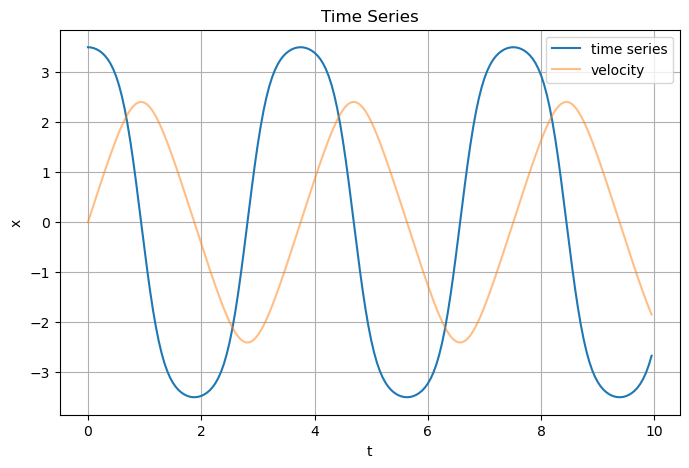

In [4]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(8,5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol[:, 1],sol[:, 0],1)

In [5]:
def log_likelihood(theta):
    a,b = theta

    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    
    return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta

In [6]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), a_min)  # Lower bounds
LB[0][1] = b_min
UB = np.full((1, D), a_max)  # Upper bounds
UB[0][1] = b_max

PLB = np.copy(LB) + 0.05
PUB = np.copy(UB) - 0.05

x0 = np.full((1, D), 0.11) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = 3.5

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.05 1.05]] [[0.45 4.95]] [[0.5 5. ]] x0: [[0.11 3.5 ]]


In [7]:
prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "display": "off"
}

#vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) # initialize VMBC object

In [8]:
#vp, results = vbmc.optimize(); # do optimization (might take a while)

In [9]:
#vp.plot();

Now that we have a Variational Posterior, we can think about defining a metric for it.

In [9]:
def euclidean_metric(vp,truth_array, n_samples = int(1e6)): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = StandardScaler(with_mean = False) # create scaler (don't bother centering)
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    return np.linalg.norm(mean-truth_scaled) # return distance between mean and truth

# call the function on our current example
#euclidean_metric(vp,np.array([[a,b]]))

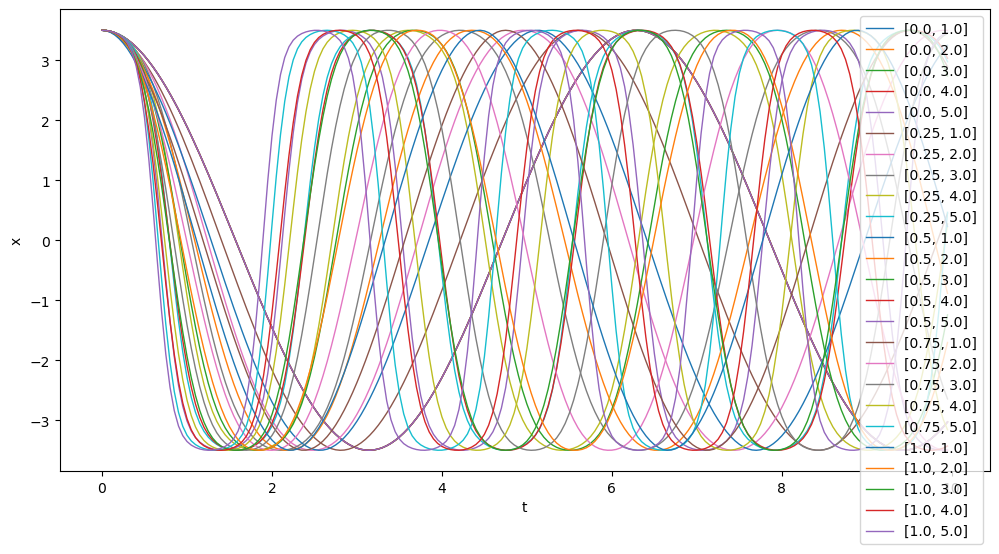

In [24]:
points = []
solutions = []
N = 5
grid = np.zeros((N,N))
for i,a in enumerate(np.linspace(0.0,1.0,N)):
    for j,b in enumerate(np.linspace(1.0,5.0,N)):
        points.append([a,b])
        sol = odeint(diffyqs, initial_condition, t, args=(a,b))
        x_true = sol[:,1]
        solutions.append(x_true)  

#solutions = solutions[0:5]
plt.figure(figsize=(12,6))
for i,sol in enumerate(solutions):
    plt.plot(t,sol, lw = 1,label = str(points[i]))
plt.xlabel('t')
plt.ylabel('x')
plt.legend()  
plt.show()  

# Heatmap data with euclidean metric

In [12]:
N = 10
grid = np.zeros((5,N))
solutions = []
for i,a in enumerate(np.linspace(a_min,a_max,5)):     # a will be y axis in grid
    for j,b in enumerate(np.linspace(b_min,b_max,N)): # b will be x axis in grid
        sol_true = odeint(diffyqs, initial_condition, t, args=(a,b))
        x_true = sol_true[:,1]
        solutions.append(x_true)
        vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
        vp, results = vbmc.optimize();
        metric = euclidean_metric(vp,np.array([[a,b]]))
        grid[i,j] = metric

np.array(grid).tofile('metrics_grid.csv', sep = ',')
#np.array(metrics).tofile('metrics.csv', sep = ',')

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.269 +/-0.012.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.270 +/-0.002.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.277 +/-0.002.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3824: RuntimeWarning: invalid value encountered in scalar subtract
  historic_fitness_range = max(es.fit.hist) - min(es.fit.hist)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.272 +/-0.002.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.265 +/-0.001.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3824: RuntimeWarning: invalid value encountered in scalar subtract
  historic_fitness_range = max(es.fit.hist) - min(es.fit.hist)


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.265 +/-0.004.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.270 +/-0.003.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.278 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.271 +/-0.003.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -9.277 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.046 +/-0.002.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4.876 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.595 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.064 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.333 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.881 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.306 +/-0.000.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: -8.045 +/-0.217.
Caution: Returned variational solution may have not converged.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.774 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.643 +/-0.001.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.202 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.422 +/-0.001.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4.919 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.208 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.488 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.034 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -8.575 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.193 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.085 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
E

c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.008 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.296 +/-0.000.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\whitening\whitening.py:341: RuntimeWarning: divide by zero encountered in log
  ] = np.log(omegaw).T


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.446 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.247 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.939 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.094 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.588 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.955 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.087 +/-0.001.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.499 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.517 +/-0.000.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 1137.656 +/-6099.529.
Caution: Returned variational solution may have not converged.


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
c:\Users\walki\.conda\envs\bpe\Lib\site-packages\cma\evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 384.386 +/-217.488.
Caution: Returned variational solution may have not converged.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -5.952 +/-0.004.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.340 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -8.550 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -6.391 +/-0.001.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -7.174 +/-0.000.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -2696.535 +/-0.001.


: 